# Residual Networks

This notebook, adapted from Deeplearning.ai's Deep Learning course, focuses on constructing a deep convolutional network using Residual Networks (ResNets). While very deep networks can represent intricate functions, training them effectively can be challenging. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), address these challenges and enable the training of much deeper networks.

**Objectives:**

- Implement the foundational building blocks of ResNets using Keras
- Combine these building blocks to develop and train a state-of-the-art neural network for image classification
- Incorporate a skip connection into the network


In [ ]:
# uncomment the following line to install the packages.
# !pip install numpy h5py matplotlib scipy Pillow pandas tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow


from test_utils import summary, comparator
import public_tests

%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

## Overview of Very Deep Neural Networks

In the previous week, the focus was on building convolutional neural networks first manually with numpy, and then using TensorFlow and Keras.

Recent advancements in neural networks have led to the development of extremely deep networks, evolving from just a few layers (e.g., AlexNet) to over a hundred layers.

- **Advantages of Deep Networks:** Very deep networks can represent complex functions and learn features at multiple levels of abstraction. Shallow layers can detect basic features like edges, while deeper layers can capture more intricate patterns.

- **Training Difficulties:** Despite their potential, deeper networks pose significant challenges. One major issue is vanishing gradients, where the gradient signal can quickly diminish to zero, making gradient descent slow and ineffective.

- **Gradient Propagation:** During backpropagation, gradients are multiplied by the weight matrix at each layer, which can cause them to decrease exponentially or, in rare cases, increase uncontrollably (a phenomenon known as exploding gradients).

- **Training Observations:** As training progresses, the magnitude of gradients for the shallower layers may rapidly decrease to zero, as illustrated below:


<img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font> <b>Figure 1</b> </u><font>  : <b>Vanishing gradient</b> <br> The speed of learning decreases very rapidly for the shallower layers as the network trains </center></caption>

## Building a Residual Network

In Residual Networks (ResNets), a "shortcut" or "skip connection" enables the model to bypass certain layers:

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font> <b>Figure 2</b> </u><font>  : A ResNet block illustrating a skip connection <br> </center></caption>

The left side of the image displays the "main path" through the network, while the right side incorporates a shortcut that adds to the main path. By stacking these ResNet blocks, a very deep network can be constructed.

ResNet blocks with shortcuts facilitate the learning of identity functions, which allows the addition of more blocks with minimal impact on training performance. This ease of learning an identity function is believed to contribute significantly to the outstanding performance of ResNets, potentially more so than the reduction of vanishing gradients.

There are two primary types of blocks in ResNets, depending on whether the input and output dimensions are the same or different: the "identity block" and the "convolutional block." Both types will be implemented in this notebook.


## Implementing the Identity Block

The identity block is a fundamental component of ResNets, used when the input activation (e.g., $a^{[l]}$) has the same dimensions as the output activation (e.g., $a^{[l+2]}$). The diagram below illustrates the individual steps involved in the identity block:

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font> <b>Figure 3</b> </u><font>  : <b>Identity block.</b> Skip connection "skips over" 2 layers. </center></caption>

In this diagram, the upper path represents the "shortcut path," and the lower path represents the "main path." The diagram includes CONV2D and ReLU steps in each layer, with an added BatchNorm step to accelerate training. BatchNorm is simple to implement in Keras, requiring just one line of code.

In this exercise, a slightly enhanced version of the identity block will be implemented, where the skip connection "skips over" 3 hidden layers instead of 2. This updated block is depicted below:

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font> <b>Figure 4</b> </u><font>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>


#### These are the individual steps:

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The third BatchNorm is normalizing the 'channels' axis.
- Note that there is **no** ReLU activation function in this component. 

Final step: 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- **Hint**: The syntax will look something like `Add()([var1,var2])`
- Then apply the ReLU activation function. This has no hyperparameters. 

### identity_block

In [4]:
def identity_block(X, f, filters, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. we'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path
    ## Set the padding = 'same'
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path
    ## Set the padding = 'valid'
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation
    ## This shows the flexibility of the Functional API to create a shortcut path.
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)

    return X

In [5]:
tf.keras.backend.set_learning_phase(False)

np.random.seed(1)
tf.random.set_seed(2)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1))
print('\033[1mWith training=False\033[0m\n')
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0])

tf.keras.backend.set_learning_phase(True)

print('\n\033[1mWith training=True\033[0m\n')
np.random.seed(1)
tf.random.set_seed(2)
A4 = identity_block(X, f=2, filters=[3, 3, 3],
                   initializer=lambda seed=0:constant(value=1))
print(np.around(A4.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))

public_tests.identity_block_test(identity_block)

With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.99992 192.99992 192.99992  96.99996]
  [ 96.99996  96.99996  96.99996  48.99998]]

 [[578.99976 578.99976 578.99976 290.99988]
  [290.99988 290.99988 290.99988 146.99994]]]
96.99996

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40732 0.40732 0.40732 0.40732]
  [0.40732 0.40732 0.40732 0.40732]]

 [[5.00011 5.00011 5.00011 3.25955]
  [3.25955 3.25955 3.25955 2.40732]]]
All tests passed!


**Expected value**

```
With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.99992 192.99992 192.99992  96.99996]
  [ 96.99996  96.99996  96.99996  48.99998]]

 [[578.99976 578.99976 578.99976 290.99988]
  [290.99988 290.99988 290.99988 146.99994]]]
96.99996

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40732 0.40732 0.40732 0.40732]
  [0.40732 0.40732 0.40732 0.40732]]

 [[5.00011 5.00011 5.00011 3.25955]
  [3.25955 3.25955 3.25955 2.40732]]]
[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]
All tests passed!
```

### The Convolutional Block

The ResNet "convolutional block" is used when the input and output dimensions differ. Unlike the identity block, the convolutional block includes a CONV2D layer in the shortcut path to adjust dimensions:

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font> <b>Figure 4</b> </u><font>  : <b>Convolutional block</b> </center></caption>

Key points about the convolutional block:

* The CONV2D layer in the shortcut path resizes the input $x$ to a dimension that matches the final addition step, similar to the matrix $W_s$ discussed in the lecture.
* To reduce the height and width of the activation dimensions by a factor of 2, a 1x1 convolution with a stride of 2 can be used.
* The CONV2D layer in the shortcut path does not apply any non-linear activation function. Its primary role is to perform a learned linear transformation that adjusts the dimensions for the addition step.
* The `initializer` argument, necessary for grading purposes, is set by default to [glorot_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform).

The details of the convolutional block are as follows:

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The BatchNorm is normalizing the 'channels' axis. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters. 
    


### convolutional_block

In [6]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X) 

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    
    ##### SHORTCUT PATH ##### 
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

In [7]:
public_tests.convolutional_block_test(convolutional_block)

tf.Tensor(
[[[0.         0.         0.6444886  0.         0.13933674 0.78552186]
  [0.01692437 0.         0.70562446 0.         0.28001052 0.6748623 ]]

 [[0.         0.         0.6704905  0.         0.18277568 0.7510617 ]
  [0.         0.         0.6880039  0.         0.25766334 0.6797846 ]]], shape=(2, 2, 6), dtype=float32)
All tests passed!


**Expected value**

```
[[[0.         0.         0.6444886  0.         0.13933674 0.78552186]
  [0.01692437 0.         0.70562446 0.         0.28001052 0.6748623 ]]

 [[0.         0.         0.6704905  0.         0.18277568 0.7510617 ]
  [0.         0.         0.6880039  0.         0.25766334 0.6797846 ]]], shape=(2, 2, 6), dtype=float32)
```

## Building a ResNet Model (50 layers)

With the necessary blocks in place, it's time to construct a deep ResNet model. The figure below details the architecture of this neural network. In the diagram, `ID BLOCK` refers to an `Identity block`, and `ID BLOCK` x3 indicates stacking 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font> <b>Figure 5</b> </u><font>  : <b>ResNet-50 model</b> </center></caption>

The ResNet-50 model includes the following components:
- Zero-padding: Pads the input with a (3,3) padding.
- Stage 1:
    - 2D Convolution: 64 filters of shape (7,7) with a stride of (2,2).
    - BatchNorm: Applied to the 'channels' axis of the input.
    - MaxPooling: Uses a (3,3) window with a stride of (2,2).
- Stage 2:
    - Convolutional Block: Three sets of filters [64,64,256], with a filter size "f" of 3 and a stride "s" of 1.
    - Identity Blocks: Two blocks with filters [64,64,256] and a filter size "f" of 3.
- Stage 3:
    - Convolutional Block: Three sets of filters [128,128,512], with a filter size "f" of 3 and a stride "s" of 2.
    - Identity Blocks: Three blocks with filters [128,128,512] and a filter size "f" of 3.
- Stage 4:
    - Convolutional Block: Three sets of filters [256,256,1024], with a filter size "f" of 3 and a stride "s" of 2.
    - Identity Blocks: Five blocks with filters [256,256,1024] and a filter size "f" of 3.
- Stage 5:
    - Convolutional Block: Three sets of filters [512,512,2048], with a filter size "f" of 3 and a stride "s" of 2.
    - Identity Blocks: Two blocks with filters [512,512,2048] and a filter size "f" of 3.
- 2D Average Pooling: Uses a (2,2) window.
- Flatten: No hyperparameters.
- Fully Connected (Dense) Layer: Reduces the input to the number of classes with a softmax activation.

### ResNet50

In [8]:
def ResNet50(input_shape = (64, 64, 3), classes = 6, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter
    
    ## Stage 3
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])

    # Stage 4
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    for  i in range(5):
        X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL
    X = AveragePooling2D((2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [9]:
tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization_22 (BatchN  (None, 32, 32, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                

 conv2d_32 (Conv2D)             (None, 15, 15, 256)  16640       ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 15, 15, 256)  0           ['activation_25[0][0]',          
                                                                  'batch_normalization_32[0][0]'] 
                                                                                                  
 activation_28 (Activation)     (None, 15, 15, 256)  0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_33

                                                                  'batch_normalization_42[0][0]'] 
                                                                                                  
 activation_37 (Activation)     (None, 8, 8, 512)    0           ['add_11[0][0]']                 
                                                                                                  
 conv2d_43 (Conv2D)             (None, 8, 8, 128)    65664       ['activation_37[0][0]']          
                                                                                                  
 batch_normalization_43 (BatchN  (None, 8, 8, 128)   512         ['conv2d_43[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_38 (Activation)     (None, 8, 8, 128)    0           ['batch_normalization_43[0][0]'] 
          

 batch_normalization_53 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_53[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_47 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_53[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_47[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_64 (Conv2D)             (None, 4, 4, 1024)   263168      ['activation_57[0][0]']          
                                                                                                  
 batch_normalization_64 (BatchN  (None, 4, 4, 1024)  4096        ['conv2d_64[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_18 (Add)                   (None, 4, 4, 1024)   0           ['activation_55[0][0]',          
                                                                  'batch_normalization_64[0][0]'] 
                                                                                                  
 activation_58 (Activation)     (None, 4, 4, 1024)   0           ['add_18[0][0]']                 
          

 add_21 (Add)                   (None, 2, 2, 2048)   0           ['activation_64[0][0]',          
                                                                  'batch_normalization_74[0][0]'] 
                                                                                                  
 activation_67 (Activation)     (None, 2, 2, 2048)   0           ['add_21[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 2048)  0           ['activation_67[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense (De

In [10]:
from outputs import ResNet50_summary

model = ResNet50(input_shape = (64, 64, 3), classes = 6)

comparator(summary(model), ResNet50_summary)


All tests passed!


As shown in the Keras Tutorial Notebook, prior to training a model, you need to configure the learning process by compiling the model.

In [11]:
np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

The model is now ready to be trained. The only thing you need now is a dataset!

Let's load your old friend, the SIGNS dataset.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> <b>Figure 6</b> </u><font color='purple'>  : <b>SIGNS dataset</b> </center></caption>


In [12]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Let's train the model on 10 epochs with a batch size of 32. On a GPU, it should take less than 2 minutes. 

In [13]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 16s 63ms/step - loss: 1.7726 - accuracy: 0.3093
Epoch 2/10
34/34 [==============================] - 2s 50ms/step - loss: 1.2026 - accuracy: 0.5389
Epoch 3/10
34/34 [==============================] - 2s 51ms/step - loss: 0.8123 - accuracy: 0.6861
Epoch 4/10
34/34 [==============================] - 2s 51ms/step - loss: 0.5453 - accuracy: 0.8019
Epoch 5/10
34/34 [==============================] - 2s 50ms/step - loss: 0.4033 - accuracy: 0.8454
Epoch 6/10
34/34 [==============================] - 2s 51ms/step - loss: 0.3355 - accuracy: 0.8778
Epoch 7/10
34/34 [==============================] - 2s 51ms/step - loss: 0.3137 - accuracy: 0.8935
Epoch 8/10
34/34 [==============================] - 2s 50ms/step - loss: 0.2120 - accuracy: 0.9278
Epoch 9/10
34/34 [==============================] - 2s 50ms/step - loss: 0.1411 - accuracy: 0.9500
Epoch 10/10
34/34 [==============================] - 2s 49ms/step - loss: 0.0844 - accuracy: 0.9722


**Expected Output**:

```
Epoch 1/10
34/34 [==============================] - 16s 64ms/step - loss: 1.7770 - accuracy: 0.3111
Epoch 2/10
34/34 [==============================] - 2s 50ms/step - loss: 1.1800 - accuracy: 0.5583
Epoch 3/10
34/34 [==============================] - 2s 51ms/step - loss: 0.7900 - accuracy: 0.6935
Epoch 4/10
34/34 [==============================] - 2s 50ms/step - loss: 0.5295 - accuracy: 0.8065
Epoch 5/10
34/34 [==============================] - 2s 50ms/step - loss: 0.3665 - accuracy: 0.8648
Epoch 6/10
34/34 [==============================] - 2s 50ms/step - loss: 0.3032 - accuracy: 0.8880
Epoch 7/10
34/34 [==============================] - 2s 51ms/step - loss: 0.2456 - accuracy: 0.9194
Epoch 8/10
34/34 [==============================] - 2s 51ms/step - loss: 0.2123 - accuracy: 0.9278
Epoch 9/10
34/34 [==============================] - 2s 50ms/step - loss: 0.2113 - accuracy: 0.9389
Epoch 10/10
34/34 [==============================] - 2s 50ms/step - loss: 0.1469 - accuracy: 0.9491
```

Let's see how this model (trained on only two epochs) performs on the test set.

In [14]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 11ms/step - loss: 0.5321 - accuracy: 0.8583
Loss = 0.5321382880210876
Test Accuracy = 0.8583333492279053


**Expected Output**:

<table>
    <tr>
        <td>
            <b>Test Accuracy</b>
        </td>
        <td>
           >0.70
        </td>
    </tr>

</table>

It tends to get much better performance when trained for ~20 epochs, but this does take more than an hour when training on a CPU. 

In [15]:
# It may take ≈1min to load the model
pre_trained_model = load_model('resnet50.h5')

In [16]:
preds = pre_trained_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 9ms/step - loss: 0.1596 - accuracy: 0.9500
Loss = 0.15958724915981293
Test Accuracy = 0.949999988079071


**Recap**:

- Very deep "plain" networks don't work in practice because vanishing gradients make them hard to train.  
- Skip connections help address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
- There are two main types of blocks: The **identity block** and the **convolutional block**. 
- Very deep Residual Networks are built by stacking these blocks together.

### Test image outside SIGNS dataset

Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 1s 836ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[9.3391151e-05 4.2750672e-02 9.2499280e-01 4.2030567e-04 3.1706784e-02
  3.5941892e-05]]
Class: 2


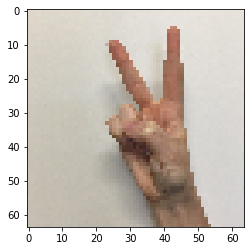

In [17]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
x2 = x 
print('Input image shape:', x.shape)
imshow(img)
prediction = pre_trained_model.predict(x2)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))


Even with high accuracy, the model might perform poorly on a new set of images. Factors such as the shape of the pictures, lighting conditions, and preprocessing steps can impact the model's performance. Reflecting on everything learned in this specialization, consider what might be causing these discrepancies.

The summary of the model

In [18]:
pre_trained_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv2d_7[0][0]']               
                                                                                           

                                                                                                  
 batch_normalization_16 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_4 (Add)                    (None, 15, 15, 256)  0           ['batch_normalization_16[0][0]', 
                                                                  'activation_12[0][0]']          
                                                                                                  
 activation_15 (Activation)     (None, 15, 15, 256)  0           ['add_4[0][0]']                  
                                                                                                  
 conv2d_18 (Conv2D)             (None, 8, 8, 128)    32896       ['activation_15[0][0]']          
          

                                                                                                  
 activation_24 (Activation)     (None, 8, 8, 512)    0           ['add_7[0][0]']                  
                                                                                                  
 conv2d_28 (Conv2D)             (None, 8, 8, 128)    65664       ['activation_24[0][0]']          
                                                                                                  
 batch_normalization_27 (BatchN  (None, 8, 8, 128)   512         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_25 (Activation)     (None, 8, 8, 128)    0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_29

 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_34[0][0]']          
                                                                                                  
 batch_normalization_38 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_35 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_38[0][0]'] 
          

 conv2d_49 (Conv2D)             (None, 4, 4, 1024)   263168      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_48 (BatchN  (None, 4, 4, 1024)  4096        ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_14 (Add)                   (None, 4, 4, 1024)   0           ['batch_normalization_48[0][0]', 
                                                                  'activation_42[0][0]']          
                                                                                                  
 activation_45 (Activation)     (None, 4, 4, 1024)   0           ['add_14[0][0]']                 
                                                                                                  
 conv2d_50

                                                                  'activation_51[0][0]']          
                                                                                                  
 activation_54 (Activation)     (None, 2, 2, 2048)   0           ['add_17[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 2048)  0           ['activation_54[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['average_pooling2d[0][0]']      
                                                                                                  
 fc6 (Dense)                    (None, 6)            12294       ['flatten[0][0]']                
          